# Задание

# На вебинаре мы говорили что долгое время CNN и RNN архитектуры были конкурируещими выяснить какая архитектура больше подходит для задачи сантимент анализа на данных с вебинара

## Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils
from tensorflow.keras import callbacks

## Loading data

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_val = pd.read_csv('../data/val.csv')

df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181467 entries, 0 to 181466
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      181467 non-null  int64 
 1   text    181467 non-null  object
 2   class   181467 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.2+ MB


## Preprocessing text

In [4]:
sw = set(get_stop_words('ru'))
exclude = set(punctuation)
morpher = MorphAnalyzer()

root_train = './prep_data_train.pkl'
root_val = './prep_data_val.pkl'
root_test = './prep_data_test.pkl'

In [5]:
def preprocess_text(txt):
    txt = str(txt)
    txt = ''.join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = [word for word in txt if word.isalnum()]
    return txt

In [6]:
# df_train['text'] = df_train['text'].apply(preprocess_text)
# df_val['text'] = df_val['text'].apply(preprocess_text)
# df_test['text'] = df_test['text'].apply(preprocess_text)

# df_train.to_pickle(root_train)
# df_val.to_pickle(root_val)
# df_test.to_pickle(root_test)

df_train = pd.read_pickle(root_train)
df_val = pd.read_pickle(root_val)
df_test = pd.read_pickle(root_test)

df_train.head()

,id,text,class
0,0,"[alisachachkaич, уезжаааааааать, тожена, хотет...",0
1,1,"[rt, galyginvadim, ребята, девчата, кино, любо...",1
2,2,"[rt, artemklyushin, ктоненавидеть, пробка, рет...",0
3,3,"[rt, epupybobv, хотеться, котлета, покиевск, з...",1
4,4,"[karinekurganova, yessboss, босапоп, есбосан, ...",1


In [7]:
y_train_cat = utils.to_categorical(df_train['class'], num_classes=2)
y_val_cat = utils.to_categorical(df_val['class'], num_classes=2)

print(y_train_cat[:5])
print(y_train_cat.shape)

print(y_val_cat[:5])
print(y_val_cat.shape)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
(181467, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(22683, 2)


## Word vectorization

In [8]:
MAX_LEN = 30

In [9]:
# w2v = Word2Vec(sentences=df_train['text'], vector_size=25, window=5, min_count=1, workers=4)
# w2v.save("word2vec.model")
w2v = Word2Vec.load("word2vec.model")

In [10]:
def text_to_wv(words, maxlen):
    result = []
    for word in words:
        if word in w2v.wv:
            result.append(list(w2v.wv[word]))
    padding = [[0]*25]*(maxlen-len(result))
    result = padding + result[-maxlen:]
    return result

In [11]:
X_train_wv = np.array([text_to_wv(text, MAX_LEN) for text in df_train['text']])
X_val_wv = np.array([text_to_wv(text, MAX_LEN) for text in df_val['text']])
X_test_wv = np.array([text_to_wv(text, MAX_LEN) for text in df_test['text']])

print(X_train_wv.shape)
print(X_val_wv.shape)
print(X_test_wv.shape)

(181467, 30, 25)
(22683, 30, 25)
(22684, 30, 25)


## 1. построить свёрточные архитектуры

In [12]:
BATCH_SIZE = 64

,filter N8,filter N16,filter N32,filter N64
epochs,,,,
0,0.634433,0.629958,0.632971,0.624022
1,0.631423,0.631556,0.647733,0.614951
2,0.624730,0.625914,0.618748,0.625620
3,0.622321,0.621369,0.614220,0.609839
4,0.622757,0.617954,0.615861,0.611838
5,0.625992,0.618558,0.613210,0.612696
6,0.617351,0.618092,0.612145,0.626500
7,0.621114,0.615916,0.609424,0.610758
8,0.618148,0.616521,0.621618,0.612212


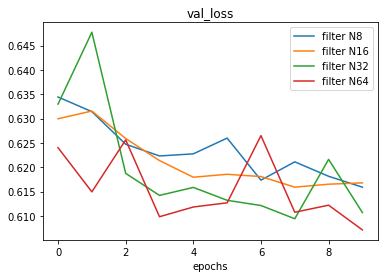

In [13]:
df_score = pd.DataFrame(columns=['epochs']).set_index('epochs')

for i in [8, 16, 32, 64]:
    conv_model = models.Sequential([
        layers.Conv1D(filters=i, kernel_size=3, activation='relu'),

        layers.GlobalMaxPool1D(),

        layers.Dense(10, activation='relu'),
        layers.Dense(2, activation='softmax'),
    ]) # init model

    conv_model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    ) # compile model

    history = conv_model.fit(
        X_train_wv, y_train_cat, 
        batch_size=BATCH_SIZE,
        epochs=10,
        validation_data=(X_val_wv, y_val_cat),
        verbose=0
    ) # fitting model
    
    df_score[f'filter N{i}'] = history.history['val_loss'] # add vak_loss in df_score

# view plots
df_score.plot(title='val_loss')
df_score # view df

#### Вывод:
- с понижением числа фильтров повышается скорость обучения
- с повышением числа фильтров - больше 8, на графиках появляются изломы
- график показвапет переобучение при 64 фильтрах

,kernel_size N3,kernel_size N5,kernel_size N7
epochs,,,
0,0.630450,0.635813,0.642582
1,0.625391,0.626865,0.638671
2,0.625298,0.626152,0.629468
3,0.626106,0.628313,0.626091
4,0.623204,0.622720,0.621410
5,0.618592,0.626699,0.630709
6,0.618785,0.620867,0.630345
7,0.621504,0.619963,0.624100
8,0.616767,0.626018,0.624230


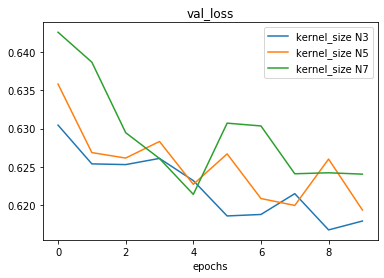

In [14]:
df_score = pd.DataFrame(columns=['epochs']).set_index('epochs')

for i in [3, 5, 7]:
    conv_model = models.Sequential([
        layers.Conv1D(filters=8, kernel_size=i, activation='relu'),

        layers.GlobalMaxPool1D(),

        layers.Dense(10, activation='relu'),
        layers.Dense(2, activation='softmax'),
    ]) # init model

    conv_model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    ) # compile model

    history = conv_model.fit(
        X_train_wv, y_train_cat, 
        batch_size=BATCH_SIZE,
        epochs=10,
        validation_data=(X_val_wv, y_val_cat),
        verbose=0
    ) # fitting model
    
    df_score[f'kernel_size N{i}'] = history.history['val_loss'] # add vak_loss in df_score

# view plots
df_score.plot(title='val_loss')
df_score # view df

#### Вывод:
- при размере = 7 дисперсия сильно возрастает

,loss
epochs,
0,0.632563
1,0.629788
2,0.621545
3,0.620294
4,0.623780
5,0.622135
6,0.631813
7,0.625591
8,0.618474


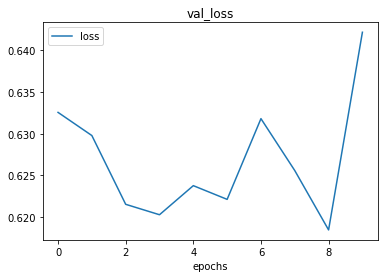

In [15]:
df_score = pd.DataFrame(columns=['epochs']).set_index('epochs')

conv_model = models.Sequential([
    layers.Conv1D(filters=8, kernel_size=3, activation='relu'),
    layers.Conv1D(filters=16, kernel_size=3, activation='relu'),

    layers.GlobalMaxPool1D(),

    layers.Dense(10, activation='relu'),
    layers.Dense(2, activation='softmax'),
]) # init model

conv_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
) # compile model

history = conv_model.fit(
    X_train_wv, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(X_val_wv, y_val_cat),
    verbose=0
) # fitting model

df_score[f'loss'] = history.history['val_loss'] # add vak_loss in df_score

# view plots
df_score.plot(title='val_loss')
df_score # view df

#### Вывод:
- при добавлении дополнительного слоя дисперсия сильно повысилась

## 2. построить различные архитектуры с RNN

,units N4,units N8,units N16,units N32
epochs,,,,
0,0.653924,0.636045,0.633427,0.627640
1,0.645934,0.626417,0.623635,0.612216
2,0.637612,0.621080,0.614391,0.615696
3,0.637559,0.622161,0.624599,0.615663
4,0.635987,0.625376,0.634512,0.617662
5,0.658826,0.617956,0.616426,0.611470
6,0.631313,0.623567,0.611273,0.629652
7,0.632956,0.621285,0.613800,0.614769
8,0.628876,0.619366,0.625795,0.618167


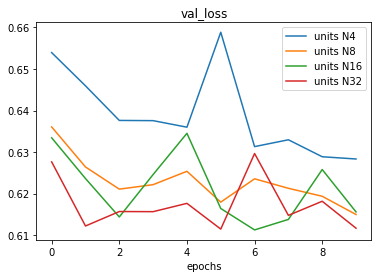

In [16]:
df_score = pd.DataFrame(columns=['epochs']).set_index('epochs')

for i in [4, 8, 16, 32]:
    conv_model = models.Sequential([
        layers.SimpleRNN(units=i),

        layers.Dense(10, activation='relu'),
        layers.Dense(2, activation='softmax'),
    ]) # init model

    conv_model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    ) # compile model

    history = conv_model.fit(
        X_train_wv, y_train_cat, 
        batch_size=BATCH_SIZE,
        epochs=10,
        validation_data=(X_val_wv, y_val_cat),
        verbose=0
    ) # fitting model
    
    df_score[f'units N{i}'] = history.history['val_loss'] # add vak_loss in df_score

# view plots
df_score.plot(title='val_loss')
df_score # view df

#### Вывод:
- С повышением числа юнитов модель стартуем с большей точностью

## 3. попробовать использовать совместно CNN и RNN

,units N4,units N8,units N16,units N32
epochs,,,,
0,0.644528,0.637424,0.635518,0.633192
1,0.631461,0.627393,0.620923,0.616614
2,0.632120,0.624572,0.616419,0.622701
3,0.620290,0.616940,0.615424,0.611404
4,0.617446,0.617074,0.617611,0.619470
5,0.629686,0.617681,0.635877,0.621561
6,0.626061,0.614354,0.617012,0.615974
7,0.622363,0.628220,0.620941,0.622989
8,0.622837,0.616193,0.616614,0.618216


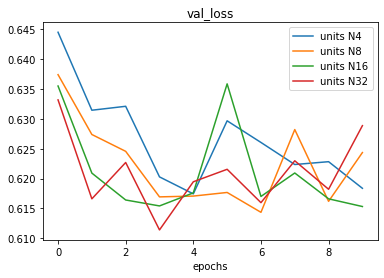

In [17]:
df_score = pd.DataFrame(columns=['epochs']).set_index('epochs')

for i in [4, 8, 16, 32]:
    conv_model = models.Sequential([
        layers.Conv1D(filters=8, kernel_size=3, activation='relu'),
        layers.SimpleRNN(units=i),

        layers.Dense(10, activation='relu'),
        layers.Dense(2, activation='softmax'),
    ]) # init model

    conv_model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    ) # compile model

    history = conv_model.fit(
        X_train_wv, y_train_cat, 
        batch_size=BATCH_SIZE,
        epochs=10,
        validation_data=(X_val_wv, y_val_cat),
        verbose=0
    ) # fitting model
    
    df_score[f'units N{i}'] = history.history['val_loss'] # add vak_loss in df_score

# view plots
df_score.plot(title='val_loss')
df_score # view df

#### Вывод:
- наблюдение показвает что при числе юнитов 4 и 16, проявиталь дисперсия

## 4. сделать выводы что получилось лучше

#### Вывод:
- При комбинированном варианте удалось получить лучший результат